In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

# Missing Values

In [2]:

df = pd.read_csv("5_data_preprocessing/5_1_missing_values/clv_data.csv")

df['lifetime_value'] = df['purchases'] * 20

df.head()

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,lifetime_value
0,0,0,NaN,Male,126895,14.0,San Francisco,0,0
1,1,1,NaN,Male,161474,14.0,Tokyo,0,0
2,2,2,24.0,Male,104723,34.0,London,1,20
3,3,3,29.0,Male,43791,28.0,London,2,40
4,4,4,18.0,Female,132181,26.0,London,2,40


In [3]:
df.isnull().sum()

Unnamed: 0             0
id                     0
age                 2446
gender                 0
income                 0
days_on_platform     141
city                   0
purchases              0
lifetime_value         0
dtype: int64

In [4]:
# method 1 :drop
drop_df = df.copy()
drop_df = drop_df.dropna()
X_d = drop_df[['age','days_on_platform','income']]
y_d = drop_df['lifetime_value']
X_train_d = X_d[:4000]
y_train_d = y_d[:4000]
X_test_d = X_d[1000:]
y_test_d = y_d[1000:]

# method 2 : use mean, mode , median
m_df = df.copy()
X_m = m_df[['age','days_on_platform','income']]
y_m = m_df['lifetime_value']
X_train_m = X_m[:4000]
y_train_m = y_m[:4000]
X_test_m = X_m[1000:]
y_test_m = y_m[1000:]
## Mean
X_train_m.loc[:,'age'] = X_train_m['age'].fillna(np.mean(X_train_m['age']))
X_test_m.loc[:,'age'] = X_test_m['age'].fillna(np.mean(X_train_m['age'])) ## Cannot use training dataset to impute
X_train_m.loc[:,'days_on_platform'] = X_train_m['days_on_platform'].fillna(np.mean(X_train_m['days_on_platform']))
X_test_m.loc[:,'days_on_platform'] = X_test_m['days_on_platform'].fillna(np.mean(X_train_m['days_on_platform'])) ## Cannot use training dataset to impute
## Median
m_df.loc[:,'age'] = df['age'].fillna(np.median(m_df['age']))
## Mode
m_df.loc[:,'age'] = m_df['age'].fillna(stats.mode(m_df['age'])[0][0])

# method 3 : ml to impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer


r_df = df.copy()
X_r = r_df[['age','days_on_platform','income']]
y_r = r_df['lifetime_value']
X_train_r = X_r[:4000]
y_train_r = y_r[:4000]
X_test_r = X_r[1000:]
y_test_r = y_r[1000:]

# regression
Imp = IterativeImputer(max_iter=10, random_state = 0)
Imp.fit(X_train_r)
X_train_r = Imp.transform(X_train_r)
X_test_r = Imp.transform(X_test_r)
X_train_r = pd.DataFrame(X_train_r)
X_train_r.columns = X_train_r.columns
X_test_r = pd.DataFrame(X_test_r)
X_test_r.columns = X_test_r.columns
r_df = pd.concat([X_train_r,X_test_r],axis = 0)

# knn
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputer.fit(X_train_r)
X_train_k = imputer.transform(X_train_r)
X_test_k = imputer.transform(X_test_r)
y_train_k = y_train_r.copy()
y_test_k = y_test_r.copy()


# check score of each method 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Drop Null Model
clf_n = RandomForestRegressor(random_state=0)
clf_n.fit(X_train_d, y_train_d)
pred_dropna = clf_n.predict(X_test_d)

# Mean Imputation Model
clf_m = RandomForestRegressor(random_state=0)
clf_m.fit(X_train_m, y_train_m)
pred_m = clf_m.predict(X_test_m)

# Regression Imputation
clf_r = RandomForestRegressor(random_state=0)
clf_r.fit(X_train_r, y_train_r)
pred_r = clf_r.predict(X_test_r)

#Nearest Neighbor Imputation
clf_n = RandomForestRegressor(random_state=0)
clf_n.fit(X_train_k, y_train_k)
pred_k = clf_n.predict(X_test_k)


print('Drop Null MAE Score: %.3f' % mean_absolute_error(y_test_d,pred_dropna))
print('Mean Impute MAE Score: %.3f' % mean_absolute_error(y_test_m,pred_m))
print('Regression MAE Score: %.3f '% mean_absolute_error(y_test_r,pred_r))
print('Nearest Neighbor MAE Score: %.3f'% mean_absolute_error(y_test_k,pred_k))

c:\Users\dania\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Drop Null MAE Score: 7.636
Mean Impute MAE Score: 10.828
Regression MAE Score: 10.795 
Nearest Neighbor MAE Score: 10.795


# Outliers

**Outlier Detection**
- Box Plots
- Z-Scores
- Isolation Forests
- DBSCAN

**Outlier Treatment**
- Removal
- Winsorize


In [5]:
df = pd.read_csv("5_data_preprocessing/5_1_missing_values/clv_data.csv")

c:\Users\dania\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='purchases'>

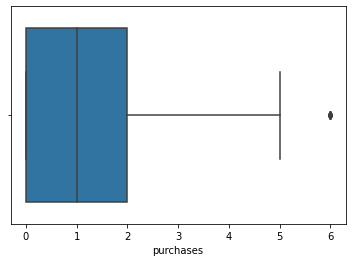

In [6]:
# method 1: boxplot
sns.boxplot(df['purchases'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x20adac805e0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x20b5ce58d90>,
 'cmins': <matplotlib.collections.LineCollection at 0x20b5cf1c220>,
 'cbars': <matplotlib.collections.LineCollection at 0x20b5cf1c550>}

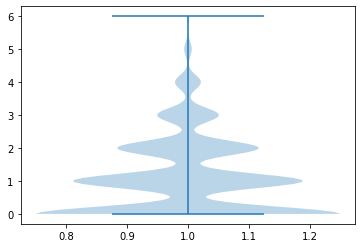

In [7]:
# method 2: violin plot
plt.violinplot(df['purchases'])

In [8]:
# method 3: 

def extract_outliers_from_boxplot(array):
    ## Get IQR
    q1 = np.quantile(array, 0.25)
    q3 = np.quantile(array, 0.75)
    med = np.median(array)

    # finding the iqr region
    iqr = q3-q1

    # finding upper and lower whiskers
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)

    outliers = array[(array <= lower_bound) | (array >= upper_bound)]
    print('Outliers within the box plot are :{}'.format(outliers))
    return outliers

extract_outliers_from_boxplot(df['purchases'])

Outliers within the box plot are :47      5
104     5
142     5
301     5
323     5
485     6
486     5
1026    5
1104    6
1112    5
1120    6
1125    5
1374    5
1504    5
1623    5
1669    6
1670    5
1809    6
1818    5
1836    5
1870    5
2180    5
2463    6
2548    5
2572    5
2605    5
2717    5
2901    5
3032    6
3080    5
3105    5
3162    5
3170    5
3291    5
3298    5
3321    5
3361    5
3380    5
3410    5
3566    5
3603    6
3631    6
3835    5
3848    5
4003    6
4141    5
4334    5
4346    5
4545    5
4597    5
4611    5
4620    5
4662    5
4691    5
4728    5
4751    5
4761    5
4895    5
4958    5
Name: purchases, dtype: int64


47      5
104     5
142     5
301     5
323     5
485     6
486     5
1026    5
1104    6
1112    5
1120    6
1125    5
1374    5
1504    5
1623    5
1669    6
1670    5
1809    6
1818    5
1836    5
1870    5
2180    5
2463    6
2548    5
2572    5
2605    5
2717    5
2901    5
3032    6
3080    5
3105    5
3162    5
3170    5
3291    5
3298    5
3321    5
3361    5
3380    5
3410    5
3566    5
3603    6
3631    6
3835    5
3848    5
4003    6
4141    5
4334    5
4346    5
4545    5
4597    5
4611    5
4620    5
4662    5
4691    5
4728    5
4751    5
4761    5
4895    5
4958    5
Name: purchases, dtype: int64

In [9]:
# method 4: z scores
purchases = df['purchases']

def percentile_outliers(array,
                        lower_bound_perc,
                        upper_bound_perc):
    
    upper_bound = np.percentile(df['purchases'], upper_bound_perc)
    lower_bound = np.percentile(df['purchases'], lower_bound_perc)
    
    outliers = array[(array <= lower_bound) | (array >= upper_bound)]
    
    return outliers

def z_score_outliers(array,
                     z_score_lower,
                     z_score_upper):

    z_scores = scipy.stats.zscore(array)
    outliers = (z_scores > 1.96) | (z_scores < -1.96)
    
    return array[outliers]

In [10]:
outliers = percentile_outliers(df['purchases'],
               upper_bound_perc = 99,
               lower_bound_perc = 1)

z_score_outliers(df['purchases'],
                     z_score_lower = -1.96,
                     z_score_upper = 1.96)

28      4
47      5
51      4
67      4
74      4
       ..
4880    4
4895    5
4897    4
4944    4
4958    5
Name: purchases, Length: 227, dtype: int64

In [11]:
# method 5: random forest 

from sklearn.ensemble import IsolationForest

features = ['age','income','days_on_platform','purchases']

## We'll do a simple drop null for now
df = df.dropna()

## Create a training-test set
X = df[features]
X_train = X[:4000]
X_test = X[1000:]

## Fit Model
clf = IsolationForest(n_estimators=50, max_samples=100)
clf.fit(X_train)

## Get Scores
df['scores'] = clf.decision_function(X_train)
df['anomaly'] = clf.predict(X)

## Get Anomalies
outliers=df.loc[df['anomaly']==-1]

outliers

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
15,15,15,31.0,Female,226249,20.0,Miami,0,-0.061339,-1
17,17,17,27.0,Female,177582,2.0,London,0,-0.032847,-1
18,18,18,10.0,Female,260,32.0,San Francisco,0,-0.068324,-1
23,23,23,10.0,Female,108804,5.0,Tokyo,2,-0.061219,-1
25,25,25,46.0,Female,112992,9.0,London,3,-0.033604,-1
...,...,...,...,...,...,...,...,...,...,...
4967,4967,4967,25.0,Male,73732,56.0,London,0,-0.004320,-1
4970,4970,4970,34.0,Female,9850,3.0,New York City,3,-0.030597,-1
4979,4979,4979,50.0,Male,90750,71.0,New York City,1,-0.105266,-1
4984,4984,4984,24.0,Female,225155,8.0,San Francisco,2,-0.083877,-1


In [12]:
# outlier treatment 

# method 1: remove using z score 
# def z_score_removal(df, column, lower_z_score, upper_z_score):
    
#     col_df = df[column]

#     z_scores = scipy.stats.zscore(purchases)
#     outliers = (z_scores > upper_z_score) | (z_scores < lower_z_score)
#     return df[~outliers]

# def percentile_removal(df, column, lower_bound_perc, upper_bound_perc):
    
#     col_df = df[column]
    
#     upper_bound = np.percentile(col_df, upper_bound_perc)
#     lower_bound = np.percentile(col_df, lower_bound_perc)

#     z_scores = scipy.stats.zscore(purchases)
#     outliers = (z_scores > upper_bound) | (z_scores < lower_bound)
#     return df[~outliers]

# filtered_df = z_score_removal(df, 'purchases', -1.96, 1.96)
# percentile_removal(df, 'purchases', lower_bound_perc = 1, upper_bound_perc = 99)



In [13]:
# remove using windscore

def winsorize(df, column, upper, lower):
    col_df = df[column]
    
    perc_upper = np.percentile(df[column],upper)
    perc_lower = np.percentile(df[column],lower)
    
    df[column] = np.where(df[column] >= perc_upper, 
                          perc_upper, 
                          df[column])
    
    df[column] = np.where(df[column] <= perc_lower, 
                          perc_lower, 
                          df[column])
    
    return df

winsorize(df, 'purchases', 97.5, 0.025)

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,scores,anomaly
2,2,2,24.0,Male,104723,34.0,London,1.0,0.046267,1
3,3,3,29.0,Male,43791,28.0,London,2.0,0.047948,1
4,4,4,18.0,Female,132181,26.0,London,2.0,0.032713,1
5,5,5,23.0,Male,12315,14.0,New York City,0.0,0.047015,1
8,8,8,46.0,Male,129157,23.0,New York City,0.0,0.032120,1
...,...,...,...,...,...,...,...,...,...,...
4986,4986,4986,23.0,Male,75425,6.0,London,1.0,0.058865,1
4989,4989,4989,47.0,Female,84987,30.0,Tokyo,0.0,0.020396,1
4990,4990,4990,33.0,Male,3020,89.0,New York City,0.0,-0.098756,-1
4991,4991,4991,36.0,Female,26173,34.0,Tokyo,0.0,0.041262,1


In [14]:
# EDA
df_agg = pd.read_csv('6_exploratory_data_analysis/Aggregated_Metrics_By_Video.csv')
df_agg_country_sub  = pd.read_csv('6_exploratory_data_analysis/Aggregated_Metrics_By_Video.csv')
df_ts  = pd.read_csv('6_exploratory_data_analysis/Video_Performance_Over_Time.csv')
df_comments = pd.read_csv('6_exploratory_data_analysis/All_Comments_Final.csv')

In [15]:
df_agg.describe()

,Com­ments ad­ded,Shares,Dis­likes,Likes,Sub­scribers lost,Sub­scribers gained,RPM (USD),CPM (USD),Av­er­age per­cent­age viewed (%),Views,Watch time (hours),Sub­scribers,Your es­tim­ated rev­en­ue (USD),Im­pres­sions,Im­pres­sions click-through rate (%)
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,222.000000,224.000000,2.240000e+02,224.000000,224.000000,224.000000,2.240000e+02,224.000000
mean,126.750000,353.924107,34.839286,2008.919643,217.620536,1608.084821,4.442040,11.442779,34.087277,4.971645e+04,2835.711522,1390.464286,259.537433,9.013573e+05,3.084152
std,948.732371,2736.321694,268.668317,15387.274015,3058.766918,15628.834115,1.789148,3.334781,15.118746,3.810302e+05,21662.566897,12647.246927,2011.119492,6.967916e+06,1.670448
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.439000,5.230000,6.000000e+01,1.068400,-21.000000,0.000000,3.650000e+02,0.490000
25%,18.000000,19.000000,1.000000,163.500000,2.000000,27.000000,3.220750,9.379500,23.602500,3.940000e+03,177.037125,19.750000,12.208250,9.947100e+04,1.925000
50%,37.000000,46.500000,4.000000,342.500000,7.000000,70.000000,4.334500,11.169500,35.120000,8.347500e+03,397.852200,62.500000,32.595500,1.541925e+05,2.895000
75%,66.250000,114.250000,11.000000,716.000000,14.000000,245.500000,5.372250,12.901000,43.462500,1.836875e+04,1145.621400,230.500000,96.814750,2.894885e+05,3.975000
max,14197.000000,39640.000000,3902.000000,225021.000000,45790.000000,229241.000000,10.387000,37.786000,76.600000,5.568487e+06,317602.353600,183451.000000,29068.652000,1.009541e+08,11.510000


<AxesSubplot:>

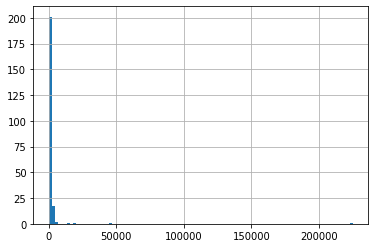

In [16]:
df_agg.Likes.hist(bins=100)

(array([222.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00000e+00, 2.25030e+04, 4.50050e+04, 6.75070e+04, 9.00090e+04,
        1.12511e+05, 1.35013e+05, 1.57515e+05, 1.80017e+05, 2.02519e+05,
        2.25021e+05]),
 <BarContainer object of 10 artists>)

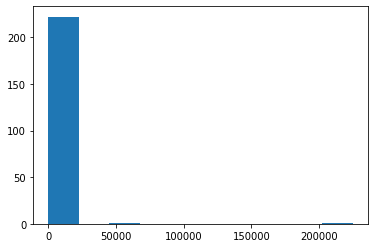

In [17]:
plt.hist(df_agg.Likes)

{'whiskers': [<matplotlib.lines.Line2D at 0x20b5de71070>,
 'caps': [<matplotlib.lines.Line2D at 0x20b5de71790>,
 'boxes': [<matplotlib.lines.Line2D at 0x20b5de63ca0>],
 'medians': [<matplotlib.lines.Line2D at 0x20b5de71eb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20b5de7b280>],
 'means': []}

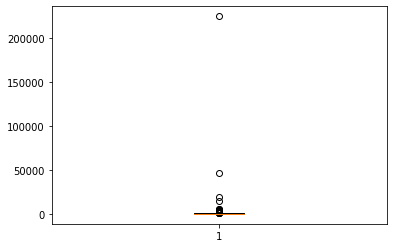

In [18]:
plt.boxplot(df_agg.Likes)

<AxesSubplot:>

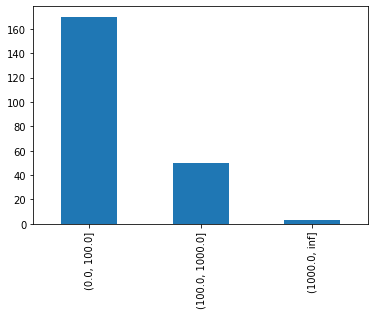

In [19]:
bins = pd.IntervalIndex.from_tuples([(0,100),(100,1000),(1000,float("inf"))])
df_agg['rev_buckets'] = pd.cut(df_agg[ 'Your es­tim­ated rev­en­ue (USD)'],bins)

rev_values = df_agg['rev_buckets'].value_counts()
rev_values.plot.bar()

In [20]:
df_agg.columns

Index(['Video', 'Video title', 'Video pub­lish time', 'Com­ments ad­ded',
       'Shares', 'Dis­likes', 'Likes', 'Sub­scribers lost',
       'Sub­scribers gained', 'RPM (USD)', 'CPM (USD)',
       'Av­er­age per­cent­age viewed (%)', 'Av­er­age view dur­a­tion',
       'Views', 'Watch time (hours)', 'Sub­scribers',
       'Your es­tim­ated rev­en­ue (USD)', 'Im­pres­sions',
       'Im­pres­sions click-through rate (%)', 'rev_buckets'],
      dtype='object')

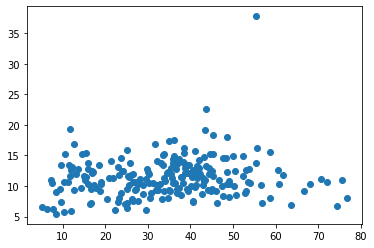

In [21]:
# EDA Multivariate 

plt.scatter(df_agg['Av­er­age per­cent­age viewed (%)'],df_agg['CPM (USD)'])

<AxesSubplot:xlabel='Av\xader\xadage per\xadcent\xadage viewed (%)', ylabel='CPM (USD)'>

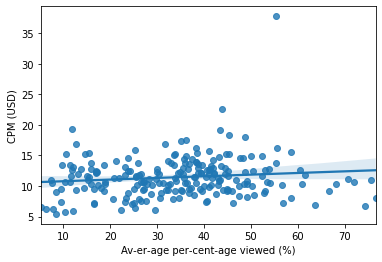

In [22]:
sns.regplot(x='Av­er­age per­cent­age viewed (%)',y='CPM (USD)',data=df_agg)

<AxesSubplot:>

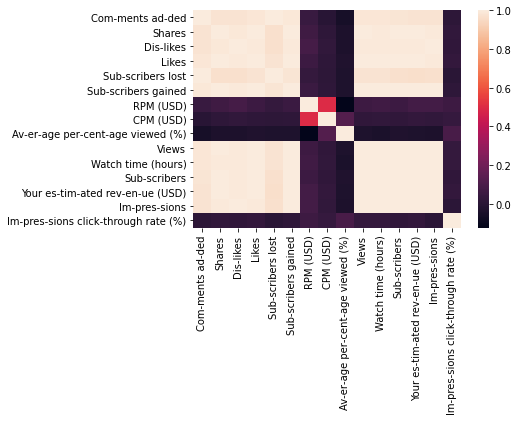

In [23]:
corr = df_agg.corr()

sns.heatmap(corr)

<AxesSubplot:>

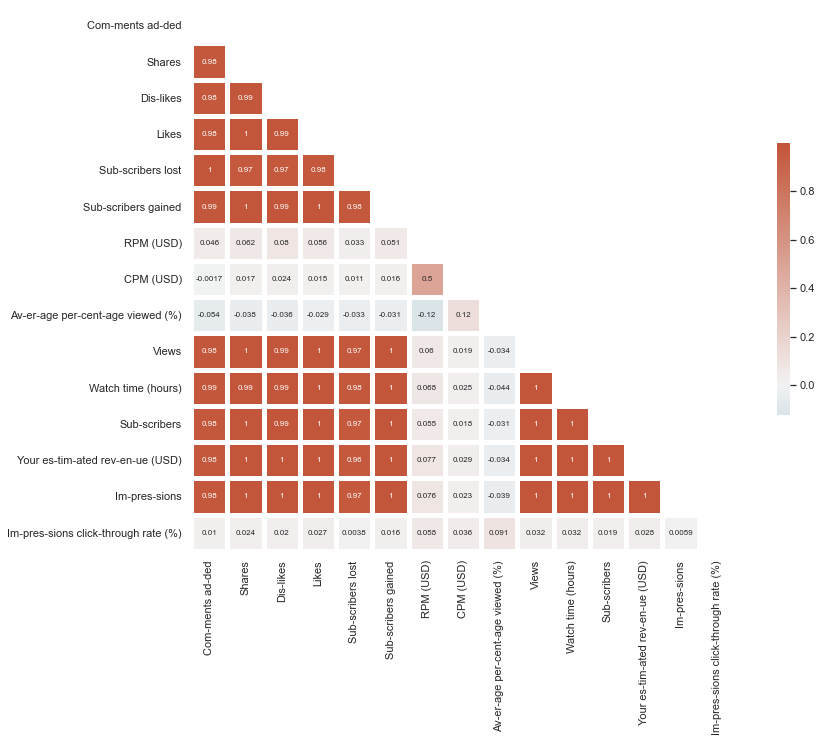

In [24]:
sns.set_theme(style='white')
corr = df_agg.corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
f, ax = plt.subplots(figsize=(15,10))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=5,
    cbar_kws={'shrink':.5},
    annot=True,
    annot_kws={'fontsize':8}
)

In [25]:
# pd.pivot_table(
#     df_agg_country_sub,
#     index='Country Code',
#     values = 'Av­er­age per­cent­age viewed (%)'
# )

In [26]:
df_ts['Date'] = pd.to_datetime(df_ts['Date'])

In [27]:
df_ts['Date']

0        2022-01-19
1        2022-01-19
2        2022-01-19
3        2022-01-19
4        2022-01-19
            ...    
111852   2017-11-21
111853   2017-11-20
111854   2017-11-19
111855   2017-11-18
111856   2017-11-01
Name: Date, Length: 111857, dtype: datetime64[ns]

In [28]:
df_ts['Date'].apply(lambda x: x.replace(day=1))

0        2022-01-01
1        2022-01-01
2        2022-01-01
3        2022-01-01
4        2022-01-01
            ...    
111852   2017-11-01
111853   2017-11-01
111854   2017-11-01
111855   2017-11-01
111856   2017-11-01
Name: Date, Length: 111857, dtype: datetime64[ns]

# Feature Engineering : categorical features encoding techniques:

* one hot encoding
* ordinal encoding
* frequency encoding
* target encoding
* probability ratio encoding
* weight of evidence encoder
* binning

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
df = pd.read_csv('./7_feature_engineering/7_1_categorical_features/airbnb_dataset_ml_process.csv')

In [31]:
df.replace([np.inf,-np.inf],np.nan,inplace=True)
df = df.dropna()
df_ = df.copy()

In [32]:
X = df_.drop(['price'],axis=1)
y = df_.copy()['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [33]:
# 2 class categorical variable
dummies = pd.get_dummies(df['expensive'])
hot_encoded_single_df = pd.concat([df,dummies],axis=1)

X = hot_encoded_single_df.drop(['price'],axis=1)
y = hot_encoded_single_df['price']

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X,y,test_size=0.33,random_state=42)

In [35]:
# multiple categorical variable
# high cardinality , too many categorical variable
mult_hot_enc = pd.get_dummies(df['neighbourhood'])
hot_encoded_df = pd.concat([df,mult_hot_enc],axis=1)
mult_hot_enc

,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",...,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodside
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X_train_me, X_test_me, y_train_me, y_test_me = train_test_split(
    X,y,
    test_size=0.33,
    random_state=42
)

In [38]:
# ordinal coding 
df_ord = df.copy()

ord_encodings = {
    'Entire home/apt':0,
    'Private room':1,
    'Shared room':2
}

df_ord['room_type_ord_enc'] = df_ord['room_type'].map(ord_encodings)

X = df_ord.drop(['price'],axis=1)
y = df_ord['price']

X_train_me, x_test_me, y_train_me, y_test_me = train_test_split(X,y,test_size=0.33,random_state=42)

In [39]:
# frequency encoding
#  to address cardinality issues

frequency_encoder = X_train.groupby(['neighbourhood']).size()
frequency_encoder

neighbourhood
Allerton            25
Arden Heights        4
Arrochar            14
Arverne             43
Astoria            480
                  ... 
Willowbrook          1
Windsor Terrace     79
Woodhaven           44
Woodlawn             8
Woodside           119
Length: 215, dtype: int64

In [42]:
X_test['neighbourhood'] = X_test['neighbourhood'].map(frequency_encoder)

In [46]:
# target encoding
df.groupby(['neighbourhood'])['price'].mean()

neighbourhood
Allerton            90.594595
Arden Heights       67.250000
Arrochar           118.250000
Arverne            158.515152
Astoria            116.018336
                      ...    
Willowbrook        249.000000
Windsor Terrace    130.687500
Woodhaven           62.722222
Woodlawn            60.090909
Woodside            89.852941
Name: price, Length: 218, dtype: float64

In [ ]:
df_te = df.copy()

In [ ]:
# scaling data 
# 1.normalization absolute max 
# 2.minmax 



In [ ]:
# cross validation
# 1, train test split
# 2 leave one out 
#3 k-fold
#4 date split
#5 time series split
#6 expanding window
#7 monte carlo 

In [50]:
df = pd.read_csv('./8_cross_validation/fraud_data.csv')

In [51]:
# train test 
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier

features = {
    'amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest'
}

X = df[features]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_preds = model.predict(X_test)
average_precision_score(y_preds,y_test)





0.9377079051782052

In [52]:
# kfold 

from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score

kf = KFold(n_splits=2,shuffle=True,random_state=42)
kf.get_n_splits(X)

folds = {}
scores = []

for train,test in kf.split(X):
    fold_number = 1
    folds[fold_number] = (df.iloc[train],df.iloc[test])
    X_train = df.iloc[train][features]
    y_train = df.iloc[train]['isFraud']
    
    X_test = df.iloc[test][features]
    y_test = df.iloc[test]['isFraud']
    
    model = RandomForestClassifier()
    model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    
    pr_auc = average_precision_score(y_preds,y_test)
    scores.append(pr_auc)
    
    fold_number += 1
    

In [54]:
scores

[0.9176742178204589, 0.9195333437462982]

In [53]:

np.mean(scores)

0.9186037807833786

In [56]:
# cross val score 

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
scores = cross_val_score(model,X,y,scoring='accuracy',cv=kf,n_jobs=-1)
np.mean(scores)

0.9934665889560274

In [58]:
# time series split

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=50000,n_splits=5)
all_scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    model = RandomForestClassifier()
    model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    pr_auc = average_precision_score(y_preds,y_test)
    all_scores.append(pr_auc)

c:\Users\dania\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
c:\Users\dania\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [59]:
all_scores

[0.013030219018574993, 0.006542833379539784, 0.0031050734682561685, nan, nan]

feature selection

In [63]:
df = pd.read_csv('./9_feature_selection/BankChurners.csv')

In [64]:
ls 11_modeling

 Volume in drive C has no label.
 Volume Serial Number is A8F7-A597

 Directory of c:\Users\dania\code\python\py_ML_Process_Course_AZ\11_modeling

16-Nov-23  12:00 PM    <DIR>          .
16-Nov-23  12:00 PM    <DIR>          ..
16-Nov-23  12:00 PM           322,081 healthcare-dataset-stroke-data.csv
16-Nov-23  12:00 PM            34,134 modeling-process-basics.ipynb
               2 File(s)        356,215 bytes
               2 Dir(s)  88,460,521,472 bytes free


In [65]:
df = pd.read_csv('./11_modeling/healthcare-dataset-stroke-data.csv')

In [66]:
df.describe(include=np.object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [68]:
# evaluation



KeyError: "None of [Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',\n       'Vehicle_Damage', 'Annual_Premiun', 'Vintage', 'Response'],\n      dtype='object')] are in the [columns]"